# Library import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset

In [3]:
# fashion_mnist 내려받기
train_dataset = torchvision.datasets.FashionMNIST("data", download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))


C:\Users\hyewwn\AppData\Roaming\Python\Python39\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
test_dataset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [6]:
train_loader = DataLoader(train_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100)

## image check

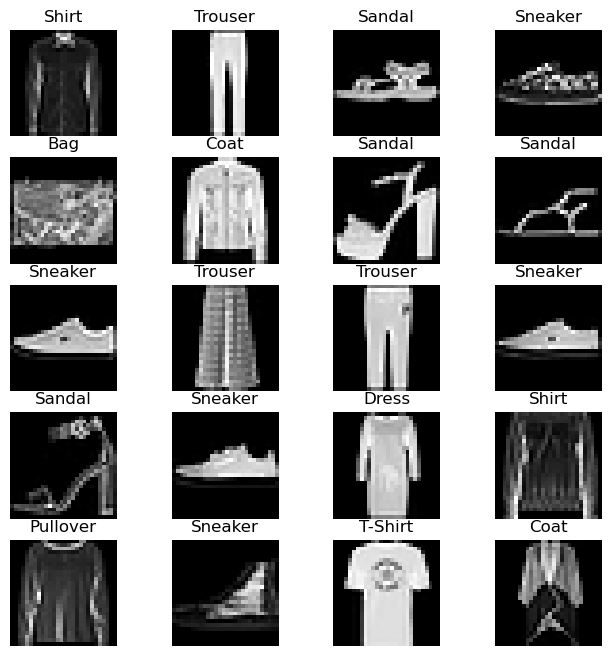

In [7]:
labels_map = {0:'T-Shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat',
              5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}

fig = plt.figure(figsize=(8,8))
columns = 4
rows = 5
for i in range(1, columns*rows+1):
  img_xy = np.random.randint(len(train_dataset))
  img = train_dataset[img_xy][0][0,:,:]
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')
plt.show()


# Models

## Genral DNN

In [8]:
# General DNN
class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features=784, out_features=256)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=10)

  def forward(self, input_data):
    out = input_data.view(-1,784)
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

In [9]:
# parameter setting
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

prediction_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100,1,28,28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1
    
    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100,1,28,28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        prediction_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)
      
      accuracy = correct * 100 / total
      loss_list.append(loss.data) # loss : Variable , loss.data : Tensor
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print("Iteration:{}, Loss:{}, Accuracy:{}%".format(count, loss.data, accuracy))

Iteration:500, Loss:0.585545003414154, Accuracy:83.54000091552734%
Iteration:1000, Loss:0.46188175678253174, Accuracy:84.73999786376953%
Iteration:1500, Loss:0.3432699143886566, Accuracy:84.27999877929688%
Iteration:2000, Loss:0.4191983938217163, Accuracy:85.23999786376953%
Iteration:2500, Loss:0.33220821619033813, Accuracy:85.81999969482422%
Iteration:3000, Loss:0.2975400686264038, Accuracy:86.66000366210938%


## CNN

In [11]:
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0),-1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

In [12]:
# Parameter setting
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [13]:
num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

prediction_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100,1,28,28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1
    
    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100,1,28,28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        prediction_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)
      
      accuracy = correct * 100 / total
      loss_list.append(loss.data) # loss : Variable , loss.data : Tensor
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print("Iteration:{}, Loss:{}, Accuracy:{}%".format(count, loss.data, accuracy))

C:\Users\hyewwn\AppData\Roaming\Python\Python39\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Iteration:500, Loss:0.44933807849884033, Accuracy:87.37999725341797%
Iteration:1000, Loss:0.36703407764434814, Accuracy:88.0%
Iteration:1500, Loss:0.3226782977581024, Accuracy:88.08000183105469%
Iteration:2000, Loss:0.22210150957107544, Accuracy:89.54000091552734%
Iteration:2500, Loss:0.17117933928966522, Accuracy:90.22000122070312%
Iteration:3000, Loss:0.17724297940731049, Accuracy:89.80999755859375%


# Transfer Learning

## Feature Extractor
FC layer (Classifier)만 학습

In [20]:
import os
import time
import copy
import glob
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [16]:
data_path = 'D:\\김밥과메추리알\\고려대학교\\Torch_study\\data\\catanddog\\train'

transform = transforms.Compose(
  [
    transforms.Resize([256,256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
  ]
)

train_dataset = torchvision.datasets.ImageFolder(
  data_path,
  transform = transform
)

train_loader = DataLoader(
  train_dataset,
  batch_size = 32,
  num_workers = 6,
  shuffle = True
)

print(len(train_dataset))

385


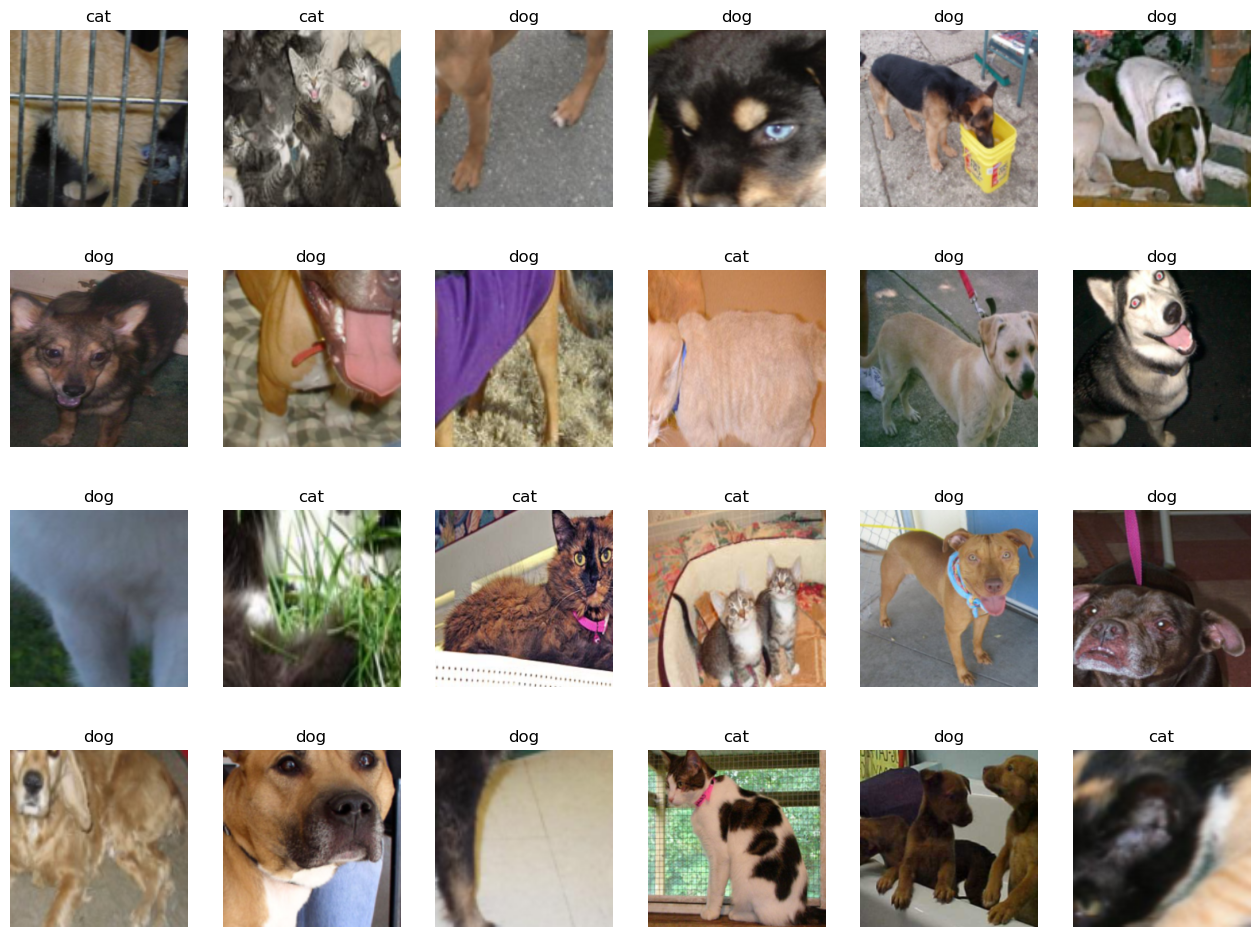

In [17]:
samples, labels = iter(train_loader).next()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
  a = fig.add_subplot(4,6,i+1)
  a.set_title(classes[labels[i].item()])
  a.axis('off')
  a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))

plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [21]:
# download pretrained model
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\hyewwn/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


내려받은 ResNet18의 합성곱층을 사용하되 파라미터에 대해서는 학습을 하지 않도록 고정

In [25]:
def set_parameters_requires_grad(model, feature_extracting=True):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False

set_parameters_requires_grad(resnet18)

완전연결층 추가

In [26]:
resnet18.fc = nn.Linear(512,2)

In [27]:
# model parameter check
for name, param in resnet18.named_parameters():
  if param.requires_grad:
    print(name, param.data)

fc.weight tensor([[ 0.0187,  0.0253, -0.0143,  ...,  0.0330, -0.0239,  0.0098],
        [-0.0230, -0.0050,  0.0078,  ..., -0.0406,  0.0076,  0.0013]])
fc.bias tensor([-0.0418, -0.0128])


In [28]:
# model create and loss function define
model = models.resnet18(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

model.fc = nn.Linear(512,2)
for param in model.fc.parameters():
  param.requires_grad = True

optimizer = optim.Adam(model.fc.parameters())
cost = nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
# model training function
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
  since = time.time()
  acc_history = []
  loss_history = []
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1,num_epochs))
    print('-'*10)

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders:
      inputs = inputs.to(device)
      labels = labels.to(device)

      model.to(device)
      optimizer.zero_grad()
      outputs = model(inputs) # forward
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs,1)
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * inputs.size(0) # 배치 합산
      running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(dataloaders.dataset)
    epoch_acc = running_corrects.double() / len(dataloaders.dataset)

    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    if epoch_acc > best_acc:
      best_acc = epoch_acc

    acc_history.append(epoch_acc.item())
    loss_history.append(epoch_loss)
    torch.save(model.state_dict(), os.path.join('D:\김밥과메추리알\고려대학교\Torch_study\data\catanddog', '{0:0=2d}.pth'.format(epoch)))
    print()
  
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
  print('Best Acc: {:4f}'.format(best_acc))
  return acc_history, loss_history

In [33]:
# model training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_acc_hist, train_loss_hist = train_model(model, train_loader, cost, optimizer, device)

Epoch 1/13
----------
Loss: 0.4533 Acc: 0.8130

Epoch 2/13
----------
Loss: 0.3386 Acc: 0.8779

Epoch 3/13
----------
Loss: 0.2975 Acc: 0.8961

Epoch 4/13
----------
Loss: 0.2601 Acc: 0.8935

Epoch 5/13
----------
Loss: 0.2959 Acc: 0.8753

Epoch 6/13
----------
Loss: 0.2632 Acc: 0.8779

Epoch 7/13
----------
Loss: 0.2718 Acc: 0.8831

Epoch 8/13
----------
Loss: 0.2413 Acc: 0.9013

Epoch 9/13
----------
Loss: 0.2387 Acc: 0.8909

Epoch 10/13
----------
Loss: 0.1831 Acc: 0.9247

Epoch 11/13
----------
Loss: 0.1952 Acc: 0.9247

Epoch 12/13
----------
Loss: 0.2046 Acc: 0.9169

Epoch 13/13
----------
Loss: 0.1948 Acc: 0.9247

Training complete in 34m 25s
Best Acc: 0.924675


In [35]:
# test
test_path = 'D:\\김밥과메추리알\\고려대학교\\Torch_study\\data\\catanddog\\test'

transform = transforms.Compose(
  [
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
  ]
)

test_dataset = torchvision.datasets.ImageFolder(
  root = test_path,
  transform=transform
)

test_loader = DataLoader(
  test_dataset,
  batch_size=32,
  num_workers=1,
  shuffle=True
)

print(len(test_dataset))

98


In [38]:
def eval_model(model, dataloaders, device):
  since = time.time()
  acc_history = []
  best_acc = 0.0

  saved_models = glob.glob('D:\\김밥과메추리알\\고려대학교\\Torch_study\\data\\catanddog\\'+'*.pth')
  saved_models.sort()
  print('saved_model:', saved_models)

  for model_path in saved_models:
    print('Loading model', model_path)

    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)
    running_corrects = 0

    for inputs, labels in dataloaders:
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.no_grad():
        outputs = model(inputs)
      
      _, preds = torch.max(outputs, 1)
      running_corrects += torch.sum(preds == labels.data)
    
    model_acc = running_corrects.double() / len(dataloaders.dataset)
    print('Acc: {:.4f}'.format(model_acc))

    if model_acc > best_acc:
      best_acc = model_acc
    
    acc_history.append(model_acc.item())
    print()
  
  time_elapsed = time.time() - since
  print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
  print('Best Acc: {:4f}'.format(best_acc))

  return acc_history
      

In [39]:
val_acc_history = eval_model(model, test_loader, device)

saved_model: ['D:\\김밥과메추리알\\고려대학교\\Torch_study\\data\\catanddog\\00.pth', 'D:\\김밥과메추리알\\고려대학교\\Torch_study\\data\\catanddog\\01.pth', 'D:\\김밥과메추리알\\고려대학교\\Torch_study\\data\\catanddog\\02.pth', 'D:\\김밥과메추리알\\고려대학교\\Torch_study\\data\\catanddog\\03.pth', 'D:\\김밥과메추리알\\고려대학교\\Torch_study\\data\\catanddog\\04.pth', 'D:\\김밥과메추리알\\고려대학교\\Torch_study\\data\\catanddog\\05.pth', 'D:\\김밥과메추리알\\고려대학교\\Torch_study\\data\\catanddog\\06.pth', 'D:\\김밥과메추리알\\고려대학교\\Torch_study\\data\\catanddog\\07.pth', 'D:\\김밥과메추리알\\고려대학교\\Torch_study\\data\\catanddog\\08.pth', 'D:\\김밥과메추리알\\고려대학교\\Torch_study\\data\\catanddog\\09.pth', 'D:\\김밥과메추리알\\고려대학교\\Torch_study\\data\\catanddog\\10.pth', 'D:\\김밥과메추리알\\고려대학교\\Torch_study\\data\\catanddog\\11.pth', 'D:\\김밥과메추리알\\고려대학교\\Torch_study\\data\\catanddog\\12.pth']
Loading model D:\김밥과메추리알\고려대학교\Torch_study\data\catanddog\00.pth
Acc: 0.8878

Loading model D:\김밥과메추리알\고려대학교\Torch_study\data\catanddog\01.pth
Acc: 0.9286

Loading model D:\김밥과메추리알\고려대학교\Torch_study\data\ca

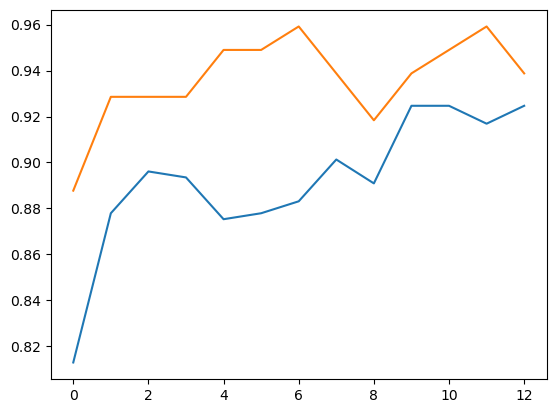

In [40]:
plt.plot(train_acc_hist)
plt.plot(val_acc_history)
plt.show()

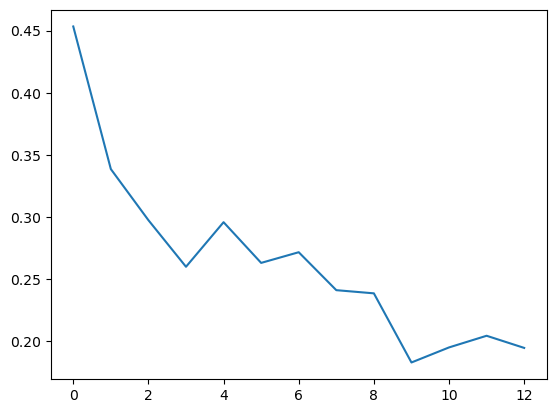

In [41]:
plt.plot(train_loss_hist)
plt.show()